# Creating a Kaggle Workflow

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Cleaning the Dataframe

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def clean_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    return df

In [4]:
train = clean_df(train)
holdout = clean_df(holdout)

## Exploring Additional Columns - SibSp and Parch

 **SibSp** - # of siblings / spouses aboard the Titanic
 
 **Parch** - # of parents / children aboard the Titanic

In [5]:
print(train['SibSp'].dtype)
print(train['Parch'].dtype)

int64
int64


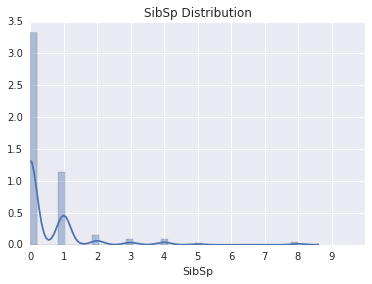

In [6]:
plt.figure(figsize=(6,4))
plt.title('SibSp Distribution')
sns.distplot(train['SibSp'])
plt.xlim([0,10])
plt.xticks(range(0,10))
plt.show()

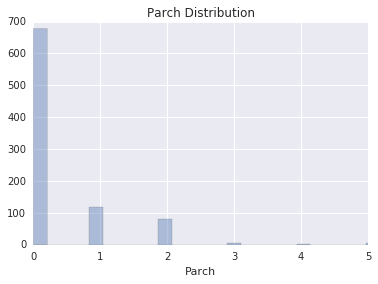

In [7]:
plt.figure(figsize=(6,4))
plt.title('Parch Distribution')
sns.distplot(train['Parch'],kde=False)
plt.xlim([0,5])
plt.xticks(range(0,6))
plt.show()

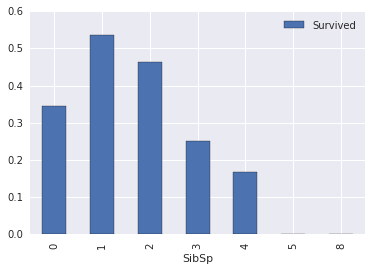

In [8]:
train.pivot_table(index=['SibSp'],values='Survived').plot.bar()

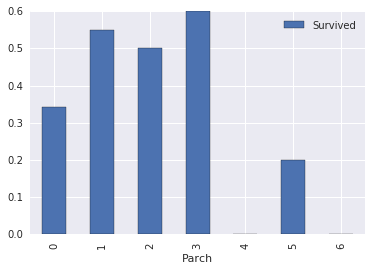

In [9]:
train.pivot_table(index=['Parch'],values='Survived').plot.bar()

In [10]:
train['Family'] = train['SibSp'] + train['Parch']
holdout['Family'] = holdout['SibSp'] + holdout['Parch']

Combining SibSp and Parch into one column called 'Family'. This will be the total count of Siblings/Spouse/Parents/Children on the ship

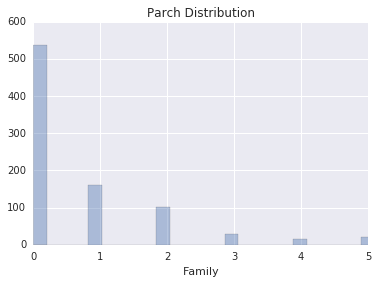

In [11]:
plt.figure(figsize=(6,4))
plt.title('Parch Distribution')
sns.distplot(train['Family'],kde=False)
plt.xlim([0,5])
plt.xticks(range(0,6))
plt.show()

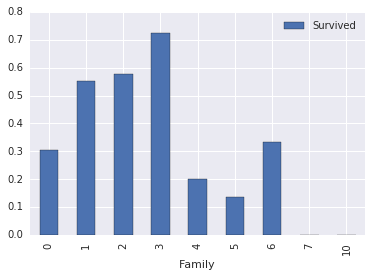

In [12]:
train.pivot_table(index=['Family'],values='Survived').plot.bar()

Based on the graph above it appears that having siblings on the boat raised your chance of survival significantly up until 3 family members on the boat. Anything more than 3 family members actually hurt your chance at survival

To keep things simple we will create a new feature called isalone. Which will be 1 if alone and 0 if passenger has one or more family members onboard.

In [13]:
def process_alone(df):
    df['isalone'] = (df['SibSp'] + df['Parch']).apply(lambda x : 1 if x == 0 else 0)
    return df

In [14]:
train = process_alone(train)
holdout = process_alone(holdout)

## Feature Selection
We will use RFECV class from the scikit-learn feature selection library

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [16]:
def select_features(df):
    #Remove any non-numeric columns
    df = df.select_dtypes(include=np.number)
    df = df.dropna(axis=1)
    all_X = df.drop(columns=['PassengerId','Survived'])
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    rfecv = RFECV(clf, cv=10)
    rfecv.fit(all_X, all_y)
    print('Number of Features %d' % rfecv.n_features_)
    print(all_X.columns[rfecv.support_])
    return list(all_X.columns[rfecv.support_])
    

In [17]:
rfe_features = select_features(train)

Number of Features 34
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'Family', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


## Model Selection

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [41]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    #Dictionary for GridSearch
    models = [
        {
        "name" : "LogisticRegression",
        "estimator" : LogisticRegression(),
        "hyperparameters" :
            {
                "solver" : ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name" : "KNeighborsClassifier",
            "estimator" : KNeighborsClassifier(),
            "hyperparameters" :
                {
                    "n_neighbors" : range(1,20,2),
                    "weights" : ['distance', 'uniform'],
                    "algorithm" : ['ball_tree', 'kd_tree', 'brute'],
                    "p" : [1,2]
                }
        },
        {
            "name" : "RandomForestClassifier",
            "estimator" : RandomForestClassifier(),
            "hyperparameters" :
                {
                    "n_estimators" : [4, 6, 9],
                    "criterion" : ["entropy", "gini"],
                    "max_depth" : [2, 5, 10],
                    "max_features" : ["log2", "sqrt"],
                    "min_samples_leaf" : [1, 5, 8],
                    "min_samples_split" : [2, 3, 5]
                }
            
        }
    ]
    
    best_models = {}
    
    for model in models:
        print('\nPerforming Grid Search on %s...' %model['name'])
        est = model['estimator']
        grid = GridSearchCV(est,param_grid = model['hyperparameters'],  cv=10,)
        grid.fit(all_X,all_y)
        print('\tScore of %f' %grid.best_score_)
        print('\tBest Parameters: %s' %grid.best_params_)
        mod_dic = {}
        mod_dic['estimator'] = grid.best_estimator_
        mod_dic['score'] = grid.best_score_
        mod_dic['parameters'] = grid.best_params_
        best_models[model['name']] = mod_dic
    return best_models

In [43]:
models = select_model(train, select_features(train))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Number of Features 34
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'Family', 'isalone'],
      dtype='object')

Performing Grid Search on LogisticRegression...
	Score of 0.819304
	Best Parameters: {'solver': 'lbfgs'}

Performing Grid Search on KNeighborsClassifier...
	Score of 0.780022
	Best Parameters: {'p': 1, 'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'uniform'}

Performing Grid Search o

## Submission File

In [44]:
def save_submission_file(estimator, features,filename='submission.csv'):
    #Takes a estimator, list of features, and outputs a csv file for kaggle submission
    submission = pd.DataFrame({'PassengerId' : holdout['PassengerId'],
                           'Survived' : estimator.predict(holdout[features])
                          }
                         )
    submission.to_csv(filename,index=False)    

In [48]:
save_submission_file(models['RandomForestClassifier']['estimator'],rfe_features)